In [13]:
import pandas as pd
import numpy as np
from glob import glob
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from tqdm import tqdm

from obspy import UTCDateTime
from dateutil import parser
from pytz import timezone
import obspy
from obspy.clients.fdsn.mass_downloader import CircularDomain, \
    Restrictions, MassDownloader




# importing the dependencies. 

import scipy as sc
from scipy import signal
import h5py

from obspy.signal.filter import envelope

import tsfel
import random
from datetime import timedelta
import calendar
from tsfel import time_series_features_extractor
from sklearn.preprocessing import StandardScaler

from scipy import stats

#%config InlineBackend.figure_format = "png"

#from Feature_Extraction import compute_hibert

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# displaying all columns from pandas dataframe
# Set display options to show all columns
pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load


import time
from datetime import datetime
import seaborn as sns

import sys
sys.path.append('../Common_Scripts/')

import seis_feature


sys.path.append('../Common_Scripts/')
from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

import json
import os
from zenodo_get import zenodo_get

In [5]:
## Loading the configuration file that contains features we want to extract. 

# Specify the file path where you want to save the JSON file
file_path = '../Common_Scripts/cfg_file_reduced.json'

# Load the JSON data from the file
with open(file_path, 'r') as f:
    cfg_file_sample = json.load(f)




## Downloading the trained model from Zenodo

In [7]:
doi = '10.5281/zenodo.11043908'  #Downloading the model trained on top 50 features
files = zenodo_get([doi])

Title: Trained Machine Learning Model to Detect Surface Events from Seismograms
Keywords: 
Publication date: 2024-04-23
DOI: 10.5281/zenodo.11043908
Total size: 102.7 MB

Link: https://zenodo.org/record/11043908/files/best_rf_model_top_50_features_50_100.joblib   size: 102.7 MB

Checksum is correct. (84af7f1738c254475462aee5d3d9de60)
All files have been downloaded.


In [12]:
# Later, you can load the model from disk
loaded_model = load('best_rf_model_top_50_features_50_100.joblib')

## Deleting the trained model since it is very large file

In [14]:
# Specify the file path
file_path = 'best_rf_model_top_50_features_50_100.joblib'

# Check if the file exists
if os.path.exists(file_path):
    # Remove the file
    os.remove(file_path)
    print(f"File '{file_path}' removed successfully.")
else:
    print(f"File '{file_path}' does not exist.")


File 'best_rf_model_top_50_features_50_100.joblib' removed successfully.


## Defining the common parameters

In [22]:
# loading the common dataset on which the model was trained so I can grab its columns. 
common_dataset = pd.read_csv('../Results/common_train_dataset_reduced.csv')

# grabbing the columns of common dataset. 
columns = common_dataset.columns[1:]


# Loading the standard scaler parameters to standardize the features in the same way as training dataset. 
scaler_params = pd.read_csv('/home/ak287/PNW_ML_Classification/results/params_standard_scaler_rf.csv')
scaler_params.index = scaler_params['Feature']
#columns = scaler_params['Feature'].values



# These are the parameters of bandpass filter function. 
lowcut = 1
highcut = 10
fs = 100
num_corners = 4


## Number of CPUs to use. 
num_cpus = 48


client = Client("IRIS")


## Stations on which we want to run the detector
stations_id = ['UW.RCM','UW.STAR', 'CC.OBSR']



# starttime from where we want to run the detector
starttime = obspy.UTCDateTime(2020, 4, 9, 13, 28, 30) -  300


# duration (in seconds) for which we want to run our detector
dur = 1800


# sampling frequency
samp_freq = 100

# input window length 
win = 150

# stride for the detector (time x freq)
stride = 30*100


# Defining the client
client = Client('IRIS')


# Defining the location code 
location = '*'

In [23]:
st_data_full = []
result_stns = []
index_stns = []
prob_stns = []

st_overall = []
st_overall_data = []
st_overall_times = []



for stn_id in tqdm(stations_id):
    
    
    ## Extracting the station
    stn = stn_id.split('.')[1]
    
    ## Extracting the network
    network = stn_id.split('.')[0]
        

    
    st = []


    
    
    try:
        # Attempt to get waveform using 'EHZ' channel
        st = client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                  network=network, channel='EHZ', location=location)
    except:
        try:
            # Attempt to get waveform using 'BHZ' channel
            st = client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                      network=network, channel='BHZ', location=location)
        except:
            try:
                # Use 'HHZ' channel as a fallback option
                st = client.get_waveforms(starttime=starttime, endtime=starttime + dur, station=stn,
                                          network=network, channel='HHZ', location=location)
            except:
                pass

    
    try:
    
        # resampling all the data to 100 Hz since thats 
        st = st.resample(samp_freq) 

        st.detrend()

        st_data_full = []
        
        ## Ideally the data should come in single stream (len(st) == 1) but if it comes in multiple streams
        ## We will take the first stream. 
        times = st[0].times()
        for i in range(len(st)):
            st_data_full = np.hstack([st_data_full, st[i].data])
        
        
            if i+1 < len(st):
                diff = st[i+1].stats.starttime - st[i].stats.endtime

                
                print(np.hstack((st[i+1].times()+times[-1],  times)))
                times = np.hstack((times, st[i+1].times()+times[-1]+diff))
               
                
                
                
                #print('Final times')
             

        st_overall_data.append(st_data_full)
        st_overall.append(st)
        st_overall_times.append(times)
        trace_data = [st_data_full[i:i+int(win*samp_freq)] for i in tqdm(range(0, len(st_data_full), stride)) if len(st_data_full[i:i+int(win*samp_freq)]) == int(win*samp_freq)]
        trace_times = [times[i] for i in tqdm(range(0, len(st_data_full), stride)) if len(st_data_full[i:i+int(win*samp_freq)]) == int(win*samp_freq)]



        trace_data = np.array(trace_data)
        tapered = apply_cosine_taper(trace_data)
        filtered = butterworth_filter(tapered, lowcut, highcut, fs, num_corners, filter_type='bandpass')

        # Applying the normalization.
        norm = filtered / np.max(abs(np.stack(filtered)), axis=1)[:, np.newaxis]

        result = []
        prob = []
        time = []
        index = []

        for i in tqdm(range(len(norm))):


            tsfel_features = time_series_features_extractor(cfg_file_sample, norm[i], fs=100)
            tr_full = obspy.Trace(norm[i])
            tr_full.stats.sampling_rate = 100
            physical_features = seis_feature.compute_physical_features(tr=tr_full, envfilter=False)

            final_features = pd.concat([tsfel_features, physical_features], axis=1)
            final_features['hod'] = (starttime).hour - 8
            final_features['dow'] = (starttime).weekday
            final_features['moy'] = (starttime).month

            features = final_features.loc[:, columns]

            final_scaler_params = scaler_params.loc[features.columns]

            for k in range(len(features.columns)):
                features.iloc[:, k] = (features.iloc[:, k] - final_scaler_params.iloc[k, 2]) / final_scaler_params.iloc[k, 3]

            # Check for NaN values in features
            if features.isnull().values.any():
                print(f"NaN values detected in iteration {i}. Skipping prediction.")

            #features['E_20_50'] = 0.001
            # extracting the results.
            result.append(loaded_model.predict(features))
            prob.append(loaded_model.predict_proba(features))
            index.append(i)


        result_stns.append(result)
        index_stns.append(index)
        prob_stns.append(prob)

    except:
        pass



100%|██████████| 60/60 [00:00<00:00, 571950.55it/s]

100%|██████████| 60/60 [00:00<00:00, 699050.67it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

[ 575.55  575.56  575.57 ...,  575.53  575.54  575.55]
[ 585.87  585.88  585.89 ...,  585.85  585.86  585.87]
[ 1203.33  1203.34  1203.35 ...,  1203.31  1203.32  1203.33]
*** Feature extraction started ***
14



  2%|▏         | 1/55 [00:00<00:12,  4.19it/s]

*** Feature extraction started ***
14



  4%|▎         | 2/55 [00:00<00:11,  4.59it/s]

*** Feature extraction started ***
14



  5%|▌         | 3/55 [00:00<00:10,  4.76it/s]

*** Feature extraction started ***
14



  7%|▋         | 4/55 [00:00<00:10,  4.83it/s]

*** Feature extraction started ***
14



  9%|▉         | 5/55 [00:01<00:10,  4.86it/s]

*** Feature extraction started ***
14



 11%|█         | 6/55 [00:01<00:10,  4.88it/s]

*** Feature extraction started ***
14



 13%|█▎        | 7/55 [00:01<00:09,  4.88it/s]

*** Feature extraction started ***
14



 15%|█▍        | 8/55 [00:01<00:09,  4.88it/s]

*** Feature extraction started ***
14



 16%|█▋        | 9/55 [00:01<00:09,  4.87it/s]

*** Feature extraction started ***
14



 18%|█▊        | 10/55 [00:02<00:09,  4.88it/s]

*** Feature extraction started ***
14



 20%|██        | 11/55 [00:02<00:09,  4.87it/s]

*** Feature extraction started ***
14



 22%|██▏       | 12/55 [00:02<00:09,  4.71it/s]

*** Feature extraction started ***
14



 24%|██▎       | 13/55 [00:02<00:09,  4.64it/s]

*** Feature extraction started ***
14



 25%|██▌       | 14/55 [00:02<00:08,  4.59it/s]

*** Feature extraction started ***
14



 27%|██▋       | 15/55 [00:03<00:08,  4.56it/s]

*** Feature extraction started ***
14



 29%|██▉       | 16/55 [00:03<00:09,  4.17it/s]

*** Feature extraction started ***
14



 31%|███       | 17/55 [00:03<00:08,  4.26it/s]

*** Feature extraction started ***
14



 33%|███▎      | 18/55 [00:03<00:08,  4.21it/s]

*** Feature extraction started ***
14



 35%|███▍      | 19/55 [00:04<00:08,  4.23it/s]

*** Feature extraction started ***
14



 36%|███▋      | 20/55 [00:04<00:08,  4.27it/s]

*** Feature extraction started ***
14



 38%|███▊      | 21/55 [00:04<00:07,  4.27it/s]

*** Feature extraction started ***
14



 40%|████      | 22/55 [00:04<00:07,  4.28it/s]

*** Feature extraction started ***
14



 42%|████▏     | 23/55 [00:05<00:08,  3.84it/s]

*** Feature extraction started ***
14



 44%|████▎     | 24/55 [00:05<00:08,  3.83it/s]

*** Feature extraction started ***
14



 45%|████▌     | 25/55 [00:05<00:07,  4.01it/s]

*** Feature extraction started ***
14



 47%|████▋     | 26/55 [00:05<00:07,  4.10it/s]

*** Feature extraction started ***
14



 49%|████▉     | 27/55 [00:06<00:06,  4.20it/s]

*** Feature extraction started ***
14



 51%|█████     | 28/55 [00:06<00:07,  3.78it/s]

*** Feature extraction started ***
14



 53%|█████▎    | 29/55 [00:06<00:07,  3.60it/s]

*** Feature extraction started ***
14



 55%|█████▍    | 30/55 [00:06<00:06,  3.80it/s]

*** Feature extraction started ***
14



 56%|█████▋    | 31/55 [00:07<00:06,  3.95it/s]

*** Feature extraction started ***
14



 58%|█████▊    | 32/55 [00:07<00:05,  4.10it/s]

*** Feature extraction started ***
14



 60%|██████    | 33/55 [00:07<00:05,  4.21it/s]

*** Feature extraction started ***
14



 62%|██████▏   | 34/55 [00:07<00:04,  4.29it/s]

*** Feature extraction started ***
14



 64%|██████▎   | 35/55 [00:08<00:04,  4.25it/s]

*** Feature extraction started ***
14



 65%|██████▌   | 36/55 [00:08<00:04,  4.24it/s]

*** Feature extraction started ***
14



 67%|██████▋   | 37/55 [00:08<00:04,  4.19it/s]

*** Feature extraction started ***
14



 69%|██████▉   | 38/55 [00:08<00:03,  4.26it/s]

*** Feature extraction started ***
14



 71%|███████   | 39/55 [00:09<00:03,  4.32it/s]

*** Feature extraction started ***
14



 73%|███████▎  | 40/55 [00:09<00:03,  4.37it/s]

*** Feature extraction started ***
14



 75%|███████▍  | 41/55 [00:09<00:03,  4.34it/s]

*** Feature extraction started ***
14



 76%|███████▋  | 42/55 [00:09<00:03,  4.33it/s]

*** Feature extraction started ***
14



 78%|███████▊  | 43/55 [00:09<00:02,  4.28it/s]

*** Feature extraction started ***
14



 80%|████████  | 44/55 [00:10<00:02,  4.31it/s]

*** Feature extraction started ***
14



 82%|████████▏ | 45/55 [00:10<00:02,  4.35it/s]

*** Feature extraction started ***
14



 84%|████████▎ | 46/55 [00:10<00:02,  4.37it/s]

*** Feature extraction started ***
14



 85%|████████▌ | 47/55 [00:10<00:01,  4.39it/s]

*** Feature extraction started ***
14



 87%|████████▋ | 48/55 [00:11<00:01,  4.39it/s]

*** Feature extraction started ***
14



 89%|████████▉ | 49/55 [00:11<00:01,  4.38it/s]

*** Feature extraction started ***
14



 91%|█████████ | 50/55 [00:11<00:01,  4.36it/s]

*** Feature extraction started ***
14



 93%|█████████▎| 51/55 [00:11<00:01,  3.75it/s]

*** Feature extraction started ***
14



 95%|█████████▍| 52/55 [00:12<00:00,  3.89it/s]

*** Feature extraction started ***
14



 96%|█████████▋| 53/55 [00:12<00:00,  4.00it/s]

*** Feature extraction started ***
14



 98%|█████████▊| 54/55 [00:12<00:00,  4.07it/s]

*** Feature extraction started ***
14



100%|██████████| 60/60 [00:00<00:00, 489607.47it/s]

100%|██████████| 60/60 [00:00<00:00, 658791.20it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

*** Feature extraction started ***
14



  2%|▏         | 1/56 [00:00<00:12,  4.25it/s]

*** Feature extraction started ***
14



  4%|▎         | 2/56 [00:00<00:12,  4.34it/s]

*** Feature extraction started ***
14



  5%|▌         | 3/56 [00:00<00:12,  4.13it/s]

*** Feature extraction started ***
14



  7%|▋         | 4/56 [00:00<00:12,  4.24it/s]

*** Feature extraction started ***
14



  9%|▉         | 5/56 [00:01<00:14,  3.61it/s]

*** Feature extraction started ***
14



 11%|█         | 6/56 [00:01<00:13,  3.69it/s]

*** Feature extraction started ***
14



 12%|█▎        | 7/56 [00:01<00:12,  3.87it/s]

*** Feature extraction started ***
14



 14%|█▍        | 8/56 [00:02<00:11,  4.00it/s]

*** Feature extraction started ***
14



 16%|█▌        | 9/56 [00:02<00:11,  4.11it/s]

*** Feature extraction started ***
14



 18%|█▊        | 10/56 [00:02<00:10,  4.20it/s]

*** Feature extraction started ***
14



 20%|█▉        | 11/56 [00:02<00:10,  4.26it/s]

*** Feature extraction started ***
14



 21%|██▏       | 12/56 [00:02<00:10,  4.23it/s]

*** Feature extraction started ***
14



 23%|██▎       | 13/56 [00:03<00:10,  4.15it/s]

*** Feature extraction started ***
14



 25%|██▌       | 14/56 [00:03<00:09,  4.21it/s]

*** Feature extraction started ***
14



 27%|██▋       | 15/56 [00:03<00:10,  4.03it/s]

*** Feature extraction started ***
14



 29%|██▊       | 16/56 [00:03<00:09,  4.11it/s]

*** Feature extraction started ***
14



 30%|███       | 17/56 [00:04<00:09,  4.12it/s]

*** Feature extraction started ***
14



 32%|███▏      | 18/56 [00:04<00:09,  4.12it/s]

*** Feature extraction started ***
14



 34%|███▍      | 19/56 [00:04<00:09,  3.80it/s]

*** Feature extraction started ***
14



 36%|███▌      | 20/56 [00:04<00:09,  3.90it/s]

*** Feature extraction started ***
14



 38%|███▊      | 21/56 [00:05<00:08,  3.96it/s]

*** Feature extraction started ***
14



 39%|███▉      | 22/56 [00:05<00:08,  4.07it/s]

*** Feature extraction started ***
14



 41%|████      | 23/56 [00:05<00:07,  4.13it/s]

*** Feature extraction started ***
14



 43%|████▎     | 24/56 [00:05<00:07,  4.19it/s]

*** Feature extraction started ***
14



 45%|████▍     | 25/56 [00:06<00:07,  4.24it/s]

*** Feature extraction started ***
14



 46%|████▋     | 26/56 [00:06<00:07,  4.26it/s]

*** Feature extraction started ***
14



 48%|████▊     | 27/56 [00:06<00:07,  3.67it/s]

*** Feature extraction started ***
14



 50%|█████     | 28/56 [00:06<00:07,  3.83it/s]

*** Feature extraction started ***
14



 52%|█████▏    | 29/56 [00:07<00:06,  3.99it/s]

*** Feature extraction started ***
14



 54%|█████▎    | 30/56 [00:07<00:06,  4.12it/s]

*** Feature extraction started ***
14



 55%|█████▌    | 31/56 [00:07<00:05,  4.18it/s]

*** Feature extraction started ***
14



 57%|█████▋    | 32/56 [00:07<00:05,  4.23it/s]

*** Feature extraction started ***
14



 59%|█████▉    | 33/56 [00:08<00:05,  4.20it/s]

*** Feature extraction started ***
14



 61%|██████    | 34/56 [00:08<00:05,  4.22it/s]

*** Feature extraction started ***
14



 62%|██████▎   | 35/56 [00:08<00:04,  4.28it/s]

*** Feature extraction started ***
14



 64%|██████▍   | 36/56 [00:08<00:04,  4.33it/s]

*** Feature extraction started ***
14



 66%|██████▌   | 37/56 [00:09<00:04,  4.37it/s]

*** Feature extraction started ***
14



 68%|██████▊   | 38/56 [00:09<00:04,  4.36it/s]

*** Feature extraction started ***
14



 70%|██████▉   | 39/56 [00:09<00:03,  4.35it/s]

*** Feature extraction started ***
14



 71%|███████▏  | 40/56 [00:09<00:03,  4.24it/s]

*** Feature extraction started ***
14



 73%|███████▎  | 41/56 [00:09<00:03,  4.24it/s]

*** Feature extraction started ***
14



 75%|███████▌  | 42/56 [00:10<00:03,  4.28it/s]

*** Feature extraction started ***
14



 77%|███████▋  | 43/56 [00:10<00:03,  4.31it/s]

*** Feature extraction started ***
14



 79%|███████▊  | 44/56 [00:10<00:02,  4.33it/s]

*** Feature extraction started ***
14



 80%|████████  | 45/56 [00:10<00:02,  4.34it/s]

*** Feature extraction started ***
14



 82%|████████▏ | 46/56 [00:11<00:02,  4.33it/s]

*** Feature extraction started ***
14



 84%|████████▍ | 47/56 [00:11<00:02,  4.28it/s]

*** Feature extraction started ***
14



 86%|████████▌ | 48/56 [00:11<00:01,  4.30it/s]

*** Feature extraction started ***
14



 88%|████████▊ | 49/56 [00:11<00:01,  4.33it/s]

*** Feature extraction started ***
14



 89%|████████▉ | 50/56 [00:12<00:01,  4.35it/s]

*** Feature extraction started ***
14



 91%|█████████ | 51/56 [00:12<00:01,  4.36it/s]

*** Feature extraction started ***
14



 93%|█████████▎| 52/56 [00:12<00:00,  4.38it/s]

*** Feature extraction started ***
14



 95%|█████████▍| 53/56 [00:12<00:00,  4.16it/s]

*** Feature extraction started ***
14



 96%|█████████▋| 54/56 [00:12<00:00,  4.24it/s]

*** Feature extraction started ***
14



 98%|█████████▊| 55/56 [00:13<00:00,  4.30it/s]

*** Feature extraction started ***
14



100%|██████████| 60/60 [00:00<00:00, 525382.55it/s]

100%|██████████| 60/60 [00:00<00:00, 738000.70it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

*** Feature extraction started ***
14



  2%|▏         | 1/56 [00:00<00:16,  3.37it/s]

*** Feature extraction started ***
14



  4%|▎         | 2/56 [00:00<00:13,  3.92it/s]

*** Feature extraction started ***
14



  5%|▌         | 3/56 [00:00<00:12,  4.14it/s]

*** Feature extraction started ***
14



  7%|▋         | 4/56 [00:00<00:12,  4.24it/s]

*** Feature extraction started ***
14



  9%|▉         | 5/56 [00:01<00:11,  4.32it/s]

*** Feature extraction started ***
14



 11%|█         | 6/56 [00:01<00:11,  4.33it/s]

*** Feature extraction started ***
14



 12%|█▎        | 7/56 [00:01<00:13,  3.66it/s]

*** Feature extraction started ***
14



 14%|█▍        | 8/56 [00:02<00:12,  3.84it/s]

*** Feature extraction started ***
14



 16%|█▌        | 9/56 [00:02<00:11,  3.98it/s]

*** Feature extraction started ***
14



 18%|█▊        | 10/56 [00:02<00:11,  4.11it/s]

*** Feature extraction started ***
14



 20%|█▉        | 11/56 [00:02<00:10,  4.21it/s]

*** Feature extraction started ***
14



 21%|██▏       | 12/56 [00:02<00:10,  4.29it/s]

*** Feature extraction started ***
14



 23%|██▎       | 13/56 [00:03<00:09,  4.33it/s]

*** Feature extraction started ***
14



 25%|██▌       | 14/56 [00:03<00:11,  3.79it/s]

*** Feature extraction started ***
14



 27%|██▋       | 15/56 [00:03<00:10,  4.00it/s]

*** Feature extraction started ***
14



 29%|██▊       | 16/56 [00:03<00:09,  4.11it/s]

*** Feature extraction started ***
14



 30%|███       | 17/56 [00:04<00:10,  3.82it/s]

*** Feature extraction started ***
14



 32%|███▏      | 18/56 [00:04<00:09,  3.99it/s]

*** Feature extraction started ***
14



 34%|███▍      | 19/56 [00:04<00:09,  3.93it/s]

*** Feature extraction started ***
14



 36%|███▌      | 20/56 [00:04<00:08,  4.08it/s]

*** Feature extraction started ***
14



 38%|███▊      | 21/56 [00:05<00:09,  3.59it/s]

*** Feature extraction started ***
14



 39%|███▉      | 22/56 [00:05<00:09,  3.53it/s]

*** Feature extraction started ***
14



 41%|████      | 23/56 [00:05<00:08,  3.78it/s]

*** Feature extraction started ***
14



 43%|████▎     | 24/56 [00:06<00:08,  3.69it/s]

*** Feature extraction started ***
14



 45%|████▍     | 25/56 [00:06<00:08,  3.51it/s]

*** Feature extraction started ***
14



 46%|████▋     | 26/56 [00:06<00:10,  2.96it/s]

*** Feature extraction started ***
14



 48%|████▊     | 27/56 [00:07<00:08,  3.29it/s]

*** Feature extraction started ***
14



 50%|█████     | 28/56 [00:07<00:07,  3.62it/s]

*** Feature extraction started ***
14



 52%|█████▏    | 29/56 [00:07<00:06,  3.88it/s]

*** Feature extraction started ***
14



 54%|█████▎    | 30/56 [00:07<00:06,  4.01it/s]

*** Feature extraction started ***
14



 55%|█████▌    | 31/56 [00:07<00:06,  4.12it/s]

*** Feature extraction started ***
14



 57%|█████▋    | 32/56 [00:08<00:05,  4.21it/s]

*** Feature extraction started ***
14



 59%|█████▉    | 33/56 [00:08<00:05,  3.93it/s]

*** Feature extraction started ***
14



 61%|██████    | 34/56 [00:08<00:05,  3.97it/s]

*** Feature extraction started ***
14



 62%|██████▎   | 35/56 [00:09<00:05,  4.04it/s]

*** Feature extraction started ***
14



 64%|██████▍   | 36/56 [00:09<00:04,  4.10it/s]

*** Feature extraction started ***
14



 66%|██████▌   | 37/56 [00:09<00:04,  4.15it/s]

*** Feature extraction started ***
14



 68%|██████▊   | 38/56 [00:09<00:04,  4.19it/s]

*** Feature extraction started ***
14



 70%|██████▉   | 39/56 [00:09<00:04,  4.20it/s]

*** Feature extraction started ***
14



 71%|███████▏  | 40/56 [00:10<00:03,  4.22it/s]

*** Feature extraction started ***
14



 73%|███████▎  | 41/56 [00:10<00:03,  4.20it/s]

*** Feature extraction started ***
14



 75%|███████▌  | 42/56 [00:10<00:03,  4.23it/s]

*** Feature extraction started ***
14



 77%|███████▋  | 43/56 [00:10<00:03,  4.23it/s]

*** Feature extraction started ***
14



 79%|███████▊  | 44/56 [00:11<00:02,  4.25it/s]

*** Feature extraction started ***
14



 80%|████████  | 45/56 [00:11<00:02,  4.27it/s]

*** Feature extraction started ***
14



 82%|████████▏ | 46/56 [00:11<00:02,  4.26it/s]

*** Feature extraction started ***
14



 84%|████████▍ | 47/56 [00:11<00:02,  4.23it/s]

*** Feature extraction started ***
14



 86%|████████▌ | 48/56 [00:12<00:01,  4.30it/s]

*** Feature extraction started ***
14



 88%|████████▊ | 49/56 [00:12<00:01,  4.34it/s]

*** Feature extraction started ***
14



 89%|████████▉ | 50/56 [00:12<00:01,  4.41it/s]

*** Feature extraction started ***
14



 91%|█████████ | 51/56 [00:12<00:01,  4.42it/s]

*** Feature extraction started ***
14



 93%|█████████▎| 52/56 [00:12<00:00,  4.42it/s]

*** Feature extraction started ***
14



 95%|█████████▍| 53/56 [00:13<00:00,  4.41it/s]

*** Feature extraction started ***
14



 96%|█████████▋| 54/56 [00:13<00:00,  4.37it/s]

*** Feature extraction started ***
14



 98%|█████████▊| 55/56 [00:13<00:00,  3.80it/s]

*** Feature extraction started ***
14



100%|██████████| 3/3 [00:43<00:00, 14.48s/it]


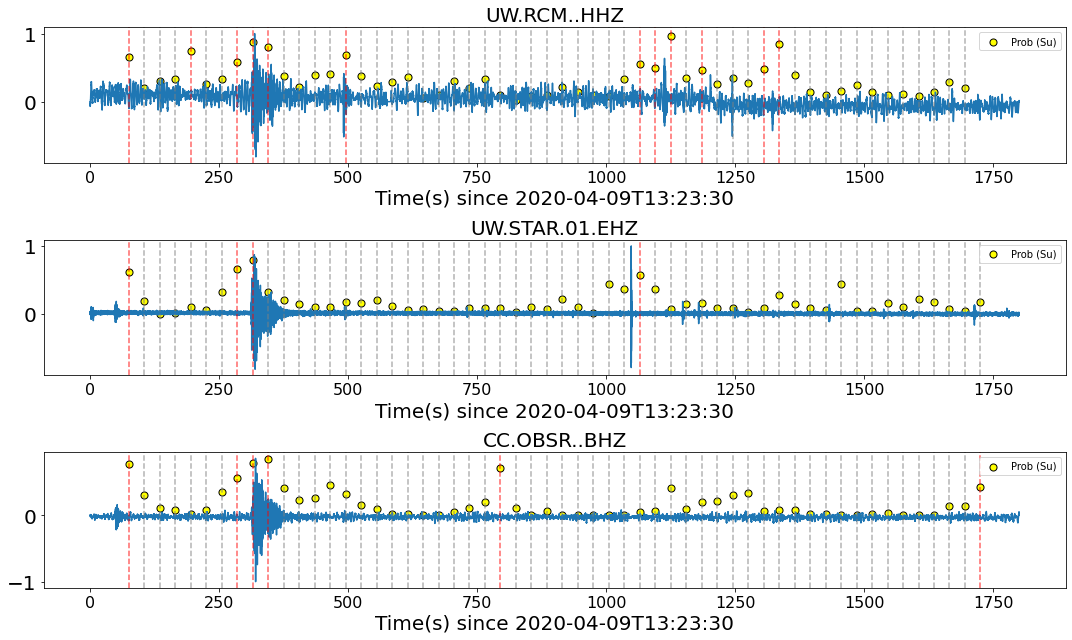

In [24]:
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

fig, axs = plt.subplots(len(st_overall_data), 1, figsize=(15, 3*len(st_overall_data)))

for k in range(len(st_overall_data)):
    
    ## This is plotting the normalized data
    axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])))
    
    ## Setting the title of the plot
    axs[k].set_title(st_overall[k][0].id, fontsize=20)
    
    ## These are the colors of detection window. 
    colors = ['black', 'blue', 'gray', 'red']
    for i in range(len(index_stns[k])):
        axs[k].axvline(30 * index_stns[k][i] + 75, ls='--', color=colors[int(result_stns[k][i])], alpha = 0.6)
    axs[k].scatter(30 * np.array(index_stns[k]) + 75, np.array(prob_stns[k])[:, :, 3], ec='k', marker='o', c='yellow', s=50, label='Prob (Su)')
    axs[k].legend()
    axs[k].set_xlabel('Time(s) since ' + str(starttime).split('.')[0], fontsize=20)
    # axs[k].set_xlim(300, 1000)  # Set x-axis limits if needed

plt.tight_layout()  # Adjust subplots to avoid overlap
plt.show()


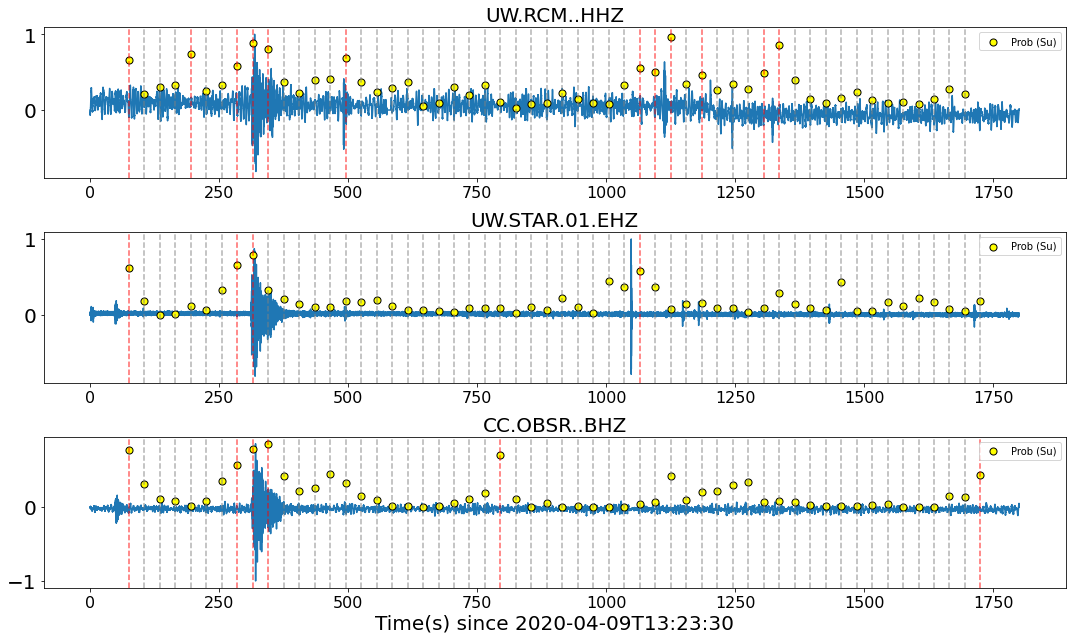

In [25]:
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

fig, axs = plt.subplots(len(st_overall_data), 1, figsize=(15, 3*len(st_overall_data)))

for k in range(len(st_overall_data)):
    
    ## This is plotting the normalized data
    axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])), zorder=1)
    
    ## Setting the title of the plot
    axs[k].set_title(st_overall[k][0].id, fontsize=20)
    
    ## These are the colors of detection window. 
    colors = ['green', 'blue', 'gray', 'red']
    for i in range(len(index_stns[k])):
        axs[k].axvline(30 * index_stns[k][i] + 75, ls='--', color=colors[int(result_stns[k][i])], alpha = 0.6)
    axs[k].scatter(30 * np.array(index_stns[k]) + 75, np.array(prob_stns[k])[:, :, 3], ec='k', marker='o', c='yellow', s=50, label='Prob (Su)', zorder=2)
    axs[k].legend()
    
    
plt.xlabel('Time(s) since ' + str(starttime).split('.')[0], fontsize=20)
    # axs[k].set_xlim(300, 1000)  # Set x-axis limits if needed

plt.tight_layout()  # Adjust subplots to avoid overlap
plt.show()


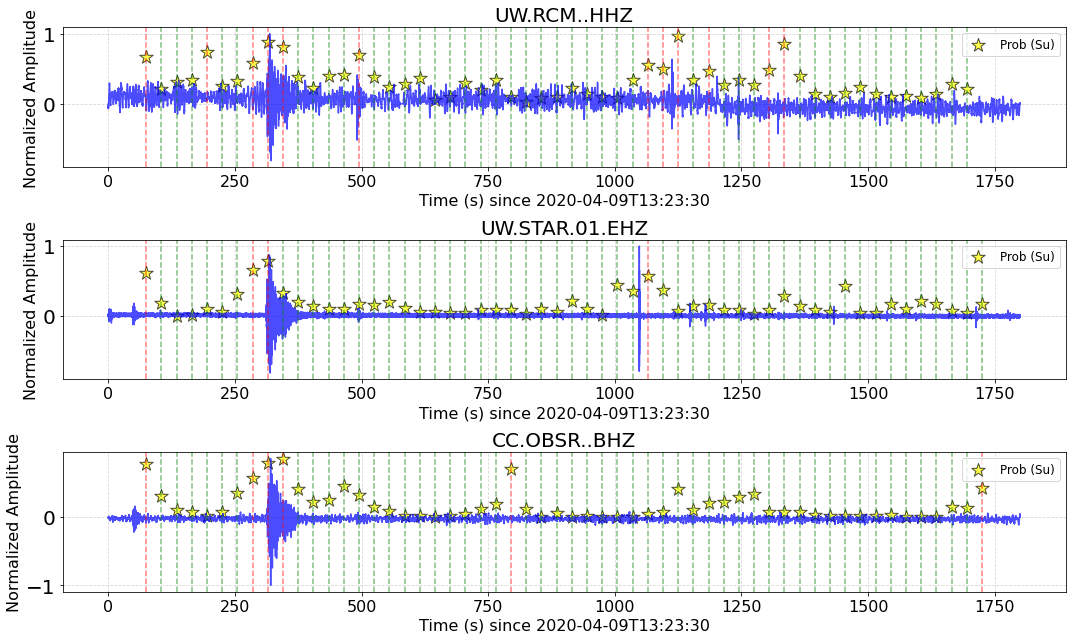

In [26]:
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

fig, axs = plt.subplots(len(st_overall_data), 1, figsize=(15, 3*len(st_overall_data)))

for k in range(len(st_overall_data)):
    axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])), color='blue', alpha=0.7)
    axs[k].set_title(st_overall[k][0].id, fontsize=20)
    colors = ['black', 'blue', 'green', 'red']
    for i in range(len(index_stns[k])):
        axs[k].axvline(30 * index_stns[k][i] + 75, ls='--', color=colors[int(result_stns[k][i])], alpha=0.5)
    axs[k].scatter(30 * np.array(index_stns[k]) + 75, np.array(prob_stns[k])[:, :, 3], ec='k', marker='*', c='yellow', s=200, label='Prob (Su)', alpha=0.7)
    axs[k].legend(fontsize=12, loc='upper right')
    axs[k].set_xlabel('Time (s) since ' + str(starttime).split('.')[0], fontsize=16)
    axs[k].set_ylabel('Normalized Amplitude', fontsize=16)
    axs[k].grid(True, linestyle='--', alpha=0.5)  # Add gridlines with transparency

plt.tight_layout()  # Adjust subplots to avoid overlap
plt.show()


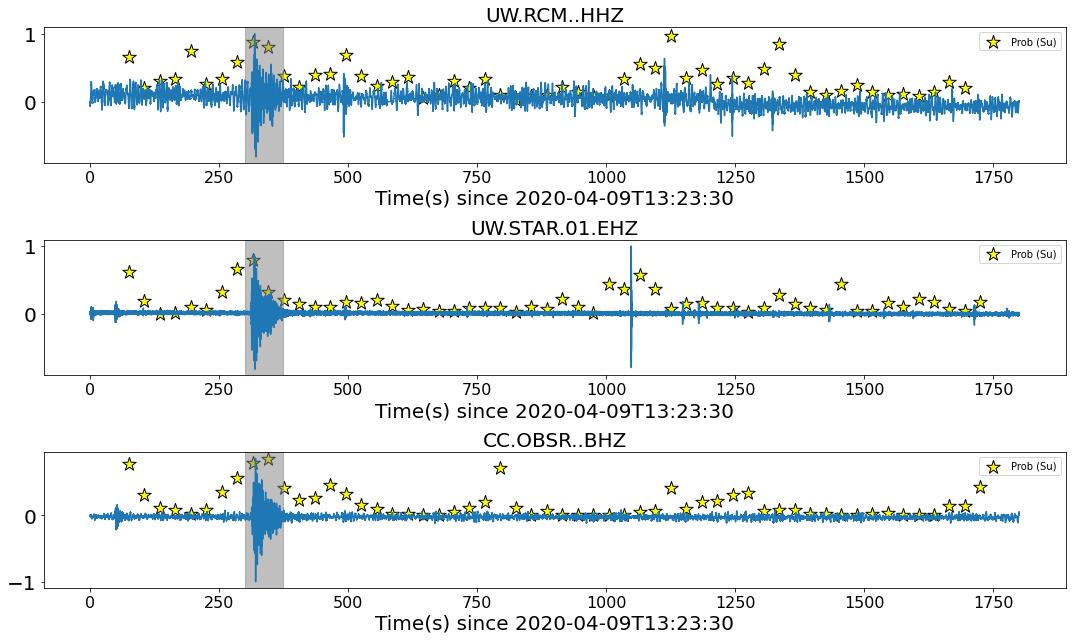

In [27]:
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

fig, axs = plt.subplots(len(st_overall_data), 1, figsize=(15, 3*len(st_overall_data)))

for k in range(len(st_overall_data)):
    axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])))
    axs[k].set_title(st_overall[k][0].id, fontsize=20)
    colors = ['black', 'blue', 'green', 'red']
    #for i in range(len(index_stns[k])):
        #axs[k].axvline(30 * index_stns[k][i] + 75, ls='--', color=colors[int(result_stns[k][i])])
    axs[k].scatter(30 * np.array(index_stns[k]) + 75, np.array(prob_stns[k])[:, :, 3], ec='k', marker='*', c='yellow', s=200, label='Prob (Su)')
    axs[k].legend()
    axs[k].set_xlabel('Time(s) since ' + str(starttime).split('.')[0], fontsize=20)
    axs[k].axvspan(300, 373, color='gray', alpha=0.5)  # Add a lightly shaded box between 300 and 700 seconds

plt.tight_layout()  # Adjust subplots to avoid overlap
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


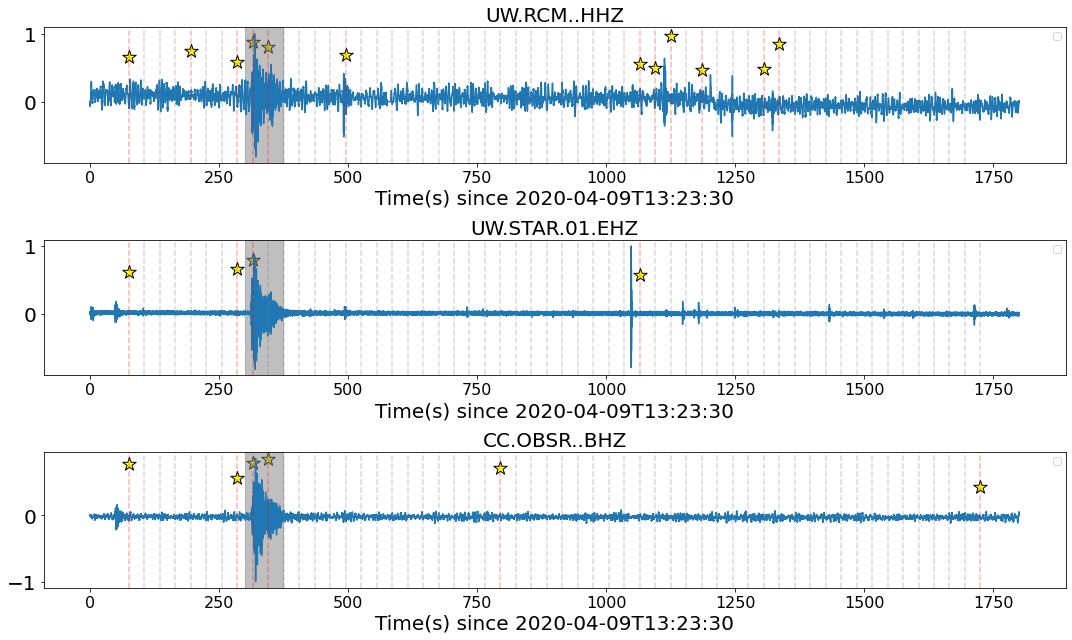

In [28]:
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

fig, axs = plt.subplots(len(st_overall_data), 1, figsize=(15, 3*len(st_overall_data)))

for k in range(len(st_overall_data)):
    axs[k].plot(st_overall_times[k], st_overall_data[k] / np.max(abs(st_overall_data[k])))
    axs[k].set_title(st_overall[k][0].id, fontsize=20)
    colors = ['black', 'blue', 'green', 'red']
    colors = ['black', 'blue', 'gray', 'red']
    for i in range(len(index_stns[k])):
        axs[k].axvline(30 * index_stns[k][i] + 75, ls='--', color=colors[int(result_stns[k][i])], alpha = 0.3)
    
    for i in range(len(index_stns[k])):
        if result_stns[k][i] == 3:
            axs[k].scatter(30 * index_stns[k][i] + 75, prob_stns[k][i][0][3], ec='k', marker='*', c='yellow', s=200)
        else:
            axs[k].scatter(30 * index_stns[k][i] + 75, prob_stns[k][i][0][3], ec='k', marker='*', c='white', s=0)
    axs[k].legend()
    axs[k].set_xlabel('Time(s) since ' + str(starttime).split('.')[0], fontsize=20)
    axs[k].axvspan(300, 373, color='gray', alpha=0.5)  # Add a lightly shaded box between 300 and 373 seconds

plt.tight_layout()  # Adjust subplots to avoid overlap
plt.show()
